In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

In [46]:
df = pd.read_csv('Combined_News_DJIA.csv')

In [47]:
df.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1984,2016-06-27,0,Barclays and RBS shares suspended from trading after tanking more than 8%,Pope says Church should ask forgiveness from gays for past treatment,Poland 'shocked' by xenophobic abuse of Poles in UK,"There will be no second referendum, cabinet agrees","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid Brexit uncertainty,No negative news about South African President allowed on state broadcaster.,Surge in Hate Crimes in the U.K. Following U.K.s Brexit Vote,...,German lawyers to probe Erdogan over alleged war crimes,"Boris Johnson says the UK will continue to ""intensify"" cooperation with the EU and tells his fellow Leave supporters they must accept the 52-48 referendum win was ""not entirely overwhelming"".",Richard Branson is calling on the UK government to hold a second EU referendum to prevent 'irreversible damage' to the country.,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon from Obama,"Brexit opinion poll reveals majority don't want second EU referendum: ""half (48%) of British adults say that they are happy with the result, with two in five (43%) saying they are unhappy with the...","Conservative MP Leave Campaigner: ""The leave campaign don't have a post-Brexit plan...""","Economists predict UK recession, further weakening of Pound following Brexit.","New EU 'superstate plan by France, Germany: Creating a European superstate limiting the powers of individual members following Britains referendum decision to leave the EU",Pakistani clerics declare transgender marriages legal under Islamic law
1985,2016-06-28,1,"2,500 Scientists To Australia: If You Want To Save The Great Barrier Reef, Stop Supporting Coal","The personal details of 112,000 French police officers have been uploaded to Google Drive in a security breach just a fortnight after two officers were murdered at their home by a jihadist.",S&amp;P cuts United Kingdom sovereign credit rating to 'AA' from 'AAA',Huge helium deposit found in Africa,CEO of the South African state broadcaster quits shortly after negative news about president is banned.,"Brexit cost investors $2 trillion, the worst one day drop ever",Hong Kong democracy activists call for return to British rule as first step to independence,Brexit: Iceland president says UK can join 'triangle' of non-EU countries,...,"US, Canada and Mexico pledge 50% of power from clean energy by 2025","There is increasing evidence that Australia is torturing refugees, medical experts claim","Richard Branson, the founder of Virgin Group, said Tuesday that the company has lost about a third of its value since the U.K. voted to leave the European Union last week.","37,000-yr-old skull from Borneo reveals surprise for scientists - Study of the ""Deep Skull"" - oldest modern human discovered in SE Asia - reveals this ancient person was not related to Indigenous ...",Palestinians stone Western Wall worshipers; police shut Temple Mount to non-Muslims,Jean-Claude Juncker asks Farage: Why are you here?,"""Romanians for Remainians"" offering a new home to the 48% of Britons who voted to stay in the EU | Bucharest newspaper's app connects loving Romanian families with needy Brits, allowing people to ...",Brexit: Gibraltar in talks with Scotland to stay in EU,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual torture' against women: Rights group Amnesty International has compiled testimonies of sexual violence used as torture by Mexican security forces. De...
1986,2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offspring of Wahhabism of Al Saud regime,UK must accept freedom of movement to access EU Market,Devastated: scientists too late to captive breed mammal lost to climate change - Australian conservationists spent 5 months obtaining permissions &amp; pl

In [48]:
df.shape

(1989, 27)

In [49]:
#fix nans
documents = []
for row in range(df.shape[0]):
    for col in range(2,27):
        if type(df.iloc[row,col])!=str:
            print(df.iloc[row,col])
            documents.append(" ")
        else:
            documents.append(df.iloc[row,col])
len(documents)

nan
nan
nan
nan
nan
nan
nan


49725

In [50]:
news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")


# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [51]:
news_df[0:5]

,document,clean_doc
0,"b""Georgia 'downs two Russian warplanes' as countries move to brink of war""",georgia downs russian warplanes countries move brink
1,b'BREAKING: Musharraf to be impeached.',breaking musharraf impeached
2,b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)',russia today columns troops roll into south ossetia footage from fighting youtube
3,"b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'",russian tanks moving towards capital south ossetia which reportedly been completely destroyed georgian artillery fire
4,"b""Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing""",afghan children raped with impunity official says this sick three year raped they nothing


In [52]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 10000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix

(49725, 10000)

In [54]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

5

In [55]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    print(terms_comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
says
 
israel
 
korea
 
north
 
china
 
russia
 
world
 
Topic 1: 
korea
 
north
 
south
 
korean
 
nuclear
 
jong
 
china
 
Topic 2: 
israel
 
gaza
 
israeli
 
palestinian
 
korea
 
north
 
hamas
 
Topic 3: 
russia
 
ukraine
 
says
 
iran
 
putin
 
russian
 
syria
 
Topic 4: 
china
 
world
 
israel
 
japan
 
chinese
 
nuclear
 
iran
 


In [56]:
#Get params and see which topics are high for specific articles, 
comps = svd_model.components_

n,d = X.shape #Featurized articles
topic_scores = np.hstack([comps@X[i:i+1,:].T for i in range(n)])
topic_scores.shape

(5, 49725)

In [57]:
#Now let's average out those scores over the surrounding 1000 articles scores to see how average scores change over time
d,n = topic_scores.shape
averages = []
i=0
start = 2008.5
end = 2016.5
dates = []
while(i<n):
    running_sum = topic_scores[:,i:i+1]
    i+=1
    count = 0
    while (i)%1000 != 0:
        running_sum = running_sum + topic_scores[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start)*i/n)
    

In [58]:
averages = np.hstack(average for average in averages)
averages.shape

(5, 49)

Text(0,0.5,'Relevance of topic')

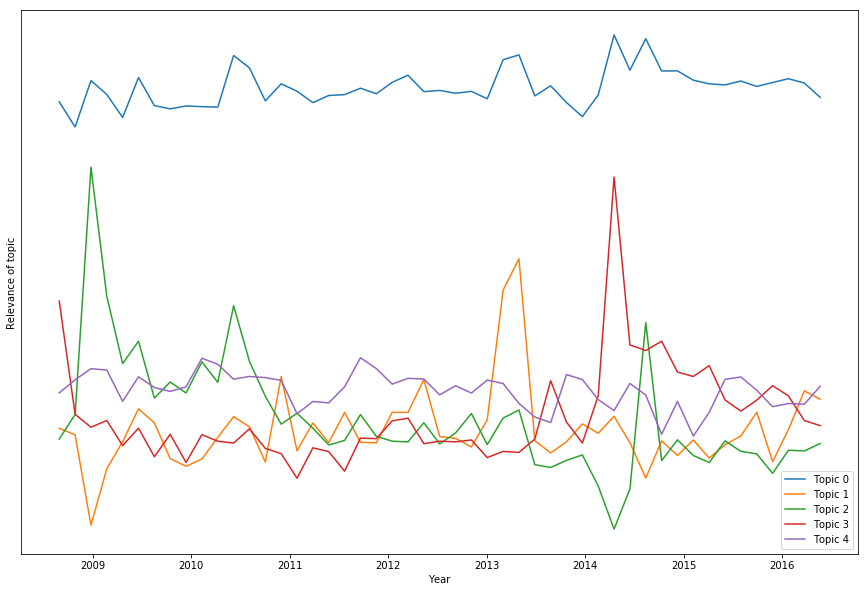

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(dates[:-1],averages.T)
plt.legend(["Topic "+str(i) for i in range(averages.shape[0])])
plt.yticks([])
plt.xlabel('Year')
plt.ylabel('Relevance of topic')

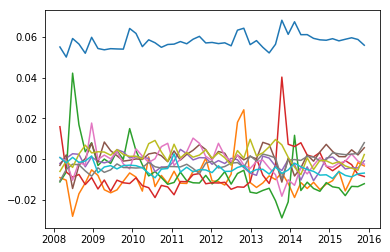

In [16]:
plt.plot(dates[:-1],averages.T)

In [38]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
lda = LatentDirichletAllocation(n_components=5, random_state=0)

In [39]:
lda.fit(X) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=5, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [40]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lda.components_):
    terms_comp = zip(terms, comp)
    print(terms_comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
police
 
canada
 
time
 
city
 
mexico
 
year
 
woman
 
Topic 1: 
million
 
state
 
people
 
islamic
 
french
 
world
 
australia
 
Topic 2: 
anti
 
putin
 
says
 
rights
 
ukraine
 
european
 
human
 
Topic 3: 
korea
 
north
 
saudi
 
nuclear
 
syria
 
russia
 
syrian
 
Topic 4: 
india
 
minister
 
isis
 
pakistan
 
billion
 
australian
 
army
 


In [41]:
#Get params and see which topics are high for specific articles, 
comps = lda.components_

n,d = X.shape #Featurized articles
topic_scores = np.hstack([comps@X[i:i+1,:].T for i in range(n)])
topic_scores.shape

(5, 49725)

In [42]:
#Now let's average out those scores over the surrounding 1000 articles scores to see how average scores change over time
d,n = topic_scores.shape
averages = []
i=0
start = 2008.5
end = 2016.5
dates = []
while(i<n):
    running_sum = topic_scores[:,i:i+1]
    i+=1
    count = 0
    while (i)%1000 != 0:
        running_sum = running_sum + topic_scores[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start)*i/n)

In [43]:
averages = np.hstack(average for average in averages)
averages.shape

(5, 49)

Text(0,0.5,'Relevance of topic')

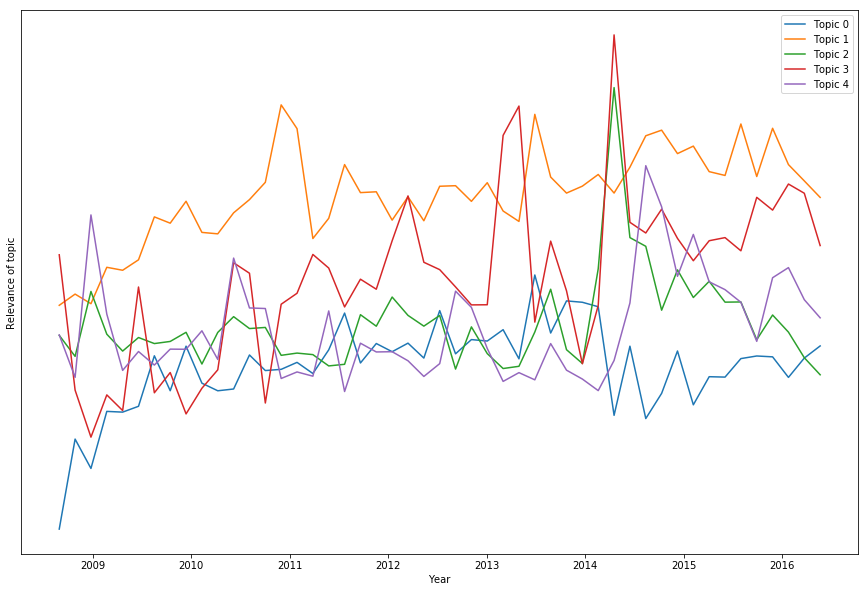

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(dates[:-1],averages.T)
plt.legend(["Topic "+str(i) for i in range(averages.shape[0])])
plt.yticks([])
plt.xlabel('Year')
plt.ylabel('Relevance of topic')